#### drive

In [1]:
!pip install git+https://github.com/logasja/lpips-pytorch.git

  Cloning https://github.com/logasja/lpips-pytorch.git to /tmp/pip-req-build-2glhmb5t
  Running command git clone --filter=blob:none --quiet https://github.com/logasja/lpips-pytorch.git /tmp/pip-req-build-2glhmb5t
  Resolved https://github.com/logasja/lpips-pytorch.git to commit 9aba7332ecab9c9af34b9787e5b40962f962f995
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for lpips_pytorch: filename=lpips_pytorch-0.0.1-py3-none-any.whl size=4953 sha256=0e8186b958049907a32c44a0d4ee7cb995919c3de5c84f56c75c145af144ff28
  Stored in directory: /tmp/pip-ephem-wheel-cache-6zuaic9l/wheels/1c/c3/93/de67e6cefaf949932ed82d083aacf73879a38a6dbb1b6228e5
Successfully built lpips_pytorch


In [2]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.4 MB/s eta 0:00:00


In [3]:
image_size = 32

#### unet unconditional

In [5]:
import torch.nn as nn

def sinusoidal_embedding(n, d):
    # n - размерность исходных данных (в нашем случае число моментов времени)
    # d - выходная размерность
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)]) # коэффициенты для d гармоник
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1)).float()
    emb = t @ wk
    embedding = torch.cat((torch.sin(emb[:, :d//2]), torch.cos(emb[:, d//2:])), dim=1) # заполните половину из d компонент синунами sin(wk*t), оставшуюся косинусами cos(wk*t), где wk - коэффициенты гармоник
    return embedding

class ResBlock(nn.Module):
    def __init__(self, cin, cout, time_ch, n_gr=8, drop=0.1):
        super().__init__()
        self.norm1 = nn.GroupNorm(n_gr, cin)
        self.act1 = nn.Sigmoid()
        self.conv1 = nn.Conv2d(cin, cout, kernel_size=(3, 3), padding=(1, 1))
        self.time_fc = nn.Linear(time_ch, cin)
        self.time_act = nn.Sigmoid()
        self.c = [cin, cout, time_ch]

    def forward(self, x, time):
        y = self.time_fc(time * self.time_act(time))[:, :, None, None]
        x += y
        out = self.norm1(x)
        out = self.conv1(out * self.act1(out))
        return out

class Attention(nn.Module):
    def __init__(self, cin, heads=1, d = None, n_gr=8):
        super().__init__()
        if d is None:
            d = cin
        self.norm = nn.GroupNorm(n_gr, cin)
        self.fc = nn.Linear(cin, heads * d * 3)
        self.last_fc = nn.Linear(heads * d, cin)
        self.scale = d ** -0.5
        self.heads = heads
        self.d = d

    def forward(self, x, t=None):
        bs, cin, h, w = x.shape
        x = x.reshape(bs, cin, -1).permute(0, 2, 1)
        qkv = self.fc(x).reshape(bs, -1, self.heads, 3 * self.d)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        attn = attn.softmax(dim=2)
        out = torch.einsum('bijh,bjhd->bihd', attn, v).reshape(bs, -1, self.heads * self.d)
        out = self.last_fc(out) + x
        out = out.permute(0, 2, 1).reshape(bs, cin, h, w)
        return out

class UpBlock(nn.Module):
    def __init__(self, cin, cout, time_ch, has_attn):
        super().__init__()
        self.res_blk = ResBlock(cin+cout, cout, time_ch)
        if has_attn:
            self.attn = Attention(cout)
        else:
            self.attn = nn.Identity()

    def forward(self, x, t):
         return self.attn(self.res_blk(x, t))

class Middle(nn.Module):
    def __init__(self, cout, ch):
        super().__init__()
        self.res1 = ResBlock(cout, cout, ch)
        self.attn = Attention(cout)
        self.res2 = ResBlock(cout, cout, ch)

    def forward(self, x, t):
        x = self.res1(x, t)
        x = self.attn(x, t)
        x = self.res2(x, t)
        return x

class DownBlock(nn.Module):
    def __init__(self, cin, cout, time_ch, has_attn):
        super().__init__()
        self.res = ResBlock(cin, cout, time_ch)
        if has_attn:
            self.attn = Attention(cout)
        else:
            self.attn = nn.Identity()
    def forward(self, x, t):
        x = self.res(x, t)
        x = self.attn(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=16):
        super().__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim * 4)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim * 4)
        self.time_embed.requires_grad_(False) # мы эмбединг слой уже инициализировали и менять его не будем
        # First half
        #self.te1 = self._make_te(time_emb_dim, time_emb_dim * 4)

        cout, cin, ch = [time_emb_dim]*3
        B = 1
        res = [1, 2, 2]
        has_attn = [False, False, True, True]
        self.conv1 = nn.Conv2d(3, ch, kernel_size=(3, 3), padding=(1, 1))
        down = []
        for i in range(len(res)):
            cout = cin * res[i]
            for _ in range(B):
                down.append(DownBlock(cin,cout, ch * 4, has_attn[i]))
                cin = cout
            if i < len(res) - 1:
                down.append(nn.Conv2d(cin, cin, (3, 3), (2, 2), (1, 1)))
        self.down = nn.ModuleList(down)
        self.middle = Middle(cout, ch*4)
        up = []
        cin = cout
        for i in range(len(res)-1, -1, -1):
            cout = cin
            for _ in range(B):
                up.append(UpBlock(cin, cout, ch * 4, has_attn[i]))
            cout = cin // res[i]
            up.append(UpBlock(cin, cout, ch * 4, has_attn[i]))
            cin = cout
            if i > 0:
                up.append(nn.ConvTranspose2d(cin, cin, (4, 4), (2, 2), (1, 1)))
        self.up = nn.ModuleList(up)
        self.norm = nn.GroupNorm(8, ch)
        self.act = nn.Sigmoid()
        self.last = nn.Conv2d(cin, 3, kernel_size=(3, 3), padding=(1, 1))


    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

    def forward(self, x, time):
        t = self.time_embed(time)
        x = self.conv1(x)
        lst = [x]
        for layer in self.down:
            if isinstance(layer, nn.Conv2d):
                x = layer(x)
            else:
                x = layer(x, t)
            lst.append(x)
        x = self.middle(x, t)
        for layer in self.up:
            if isinstance(layer, nn.ConvTranspose2d):
                x = layer(x)
            else:
                connection = lst.pop()
                x = torch.cat((x, connection), dim=1)
                x = layer(x, t)
        x = self.norm(x)
        x = self.last(x * self.act(x))
        return x

#### ddpm unconditional

In [6]:
# DDPM class
class DDPM(nn.Module):
    def __init__(self, network, # Unet
                 n_steps=1000, # YOUR CODE HERE (число шагов диффузии)
                 min_beta=1e-4, # YOUR CODE HERE
                 max_beta=1e-2, # YOUR CODE HERE
                 device=None,
                 image_chw=(3, image_size, image_size)):
        super().__init__()
        self.n_T = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device) # Ваш backbone (Unet), реализуете его ниже
        self.betas = torch.linspace(min_beta, max_beta, self.n_T).to(device) # Задайте beta по любой понравившейся сетке, как на семинаре
        self.alphas = (1 - self.betas)
        self.alpha_bars = (1 - self.betas).cumprod(axis=0)

    def forward(self, x0, t, eta=None):
        # Прямой проход диффузии (детерменированный марковский процесс)
        # :param x0 - исходная картинка (тензор формы [B,C,H,W])
        # :param t - шаг зашумления (тензор формы [B,1])
        # :param eta - \epsilon_t - добавочный шум на шаге зашумления t (тензор формы [B,C,H,W])

        if eta is None:
            eta = torch.randn_like(x0) # если шум не определен - инициализируйте его гауссом N(0,1) сами
        alpha_t = self.alpha_bars[t][:, None, None, None]
        noised_x = x0 * (alpha_t ** 0.5) + eta * (1 - alpha_t) ** 0.5
        return noised_x

    def backward(self, x, t, guide_w=None):
        # Обратный процесс. Здесь вам предстоит восстановить добавочный шум eta из зашумлённой картинки x на шаге t нейросетью
        eta_pred = self.network(x, t)
        return eta_pred

    def sample(self, n_samples, size, x=None):
        # Starting from random noise
        c, h, w = size
        if x is None:
            x = torch.randn([n_samples, c, h, w]).to(self.device) # Начинаем генерить картинки с гауссовского шума N(0,1) ([n_samples, c, h, w])

        for idx, t in enumerate(range(self.n_T-1, -1, -1)): # Денойзим наши картинки для каждого шага, начиная с последнего
            # Estimating noise to be removed
            time_tensor =  torch.tensor([t]*n_samples).reshape(-1, 1).long().to(device)  # [n_samples, 1].long()
            eta_theta = self.backward(x, time_tensor.reshape(-1)) #  Предсказываем добавочный шум нейросетью

            alpha_t = self.alphas[time_tensor][:, :, None, None]
            alpha_t_bar = self.alpha_bars[time_tensor][:, :, None, None]
            beta_t = self.betas[time_tensor][:, :, None, None]
            alpha_t_m1_bar = self.alpha_bars[time_tensor-1][:, :, None, None]

            x = (x - (1 - alpha_t) / (1 - alpha_t_bar)**0.5 * eta_theta) / (alpha_t**0.5)  # Вычитаем добавочный шум из картинки
            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)
                sigma_t = ((1-alpha_t_m1_bar) / (1-alpha_t_bar) * beta_t)**0.5 # определите сигму по любому из предлагаемых DDPM способов
                x = x + sigma_t * z
        return x

    def backward_dif(self, noise):
        n_sample = noise.shape[0]
        size = noise.shape[1:]
        device = noise.device
        x_i = self.sample(n_sample, size, x=noise)
        return x_i

    def compute_x0(self, x_t, timestep, guide_w=None):
        # computes x0 from x_t
        eps = self.backward(x_t, timestep)
        alpha_t = self.alpha_bars[timestep][:, None, None, None]
        x0 = (x_t - (1 - alpha_t) ** 0.5 * eps) / (alpha_t ** 0.5)
        return x0

#### dataloaders

In [7]:
import torch
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image


def generate_noise_img_pairs(mu_real, path_noise, path_images,
                             shape=(64, 3, 32, 32), batches_num=100,
                             denormalize=None,
                             device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    # generated dataset of noise-image pairs for reg loss
    # save noise and images as tensors with shape=shape
    assert path_noise != path_images
    mu_real.to(device)
    mu_real.eval()
    with torch.no_grad():
        for i in range(batches_num):
            print(i)
            noise = torch.randn(shape, device=device)
            images = mu_real.backward(noise)
            torch.save(noise.detach().cpu(), path_noise + '/{}.pt'.format(i))
            torch.save(images.detach().cpu(), path_images + '/{}.pt'.format(i))


class MyDataset(Dataset):
    def __init__(self, path_noise, path_images, tf=None):
        self.noise = sorted(os.listdir(path_noise))
        self.images = sorted(os.listdir(path_images))
        self.bs = torch.load(os.path.join(path_noise, self.noise[0])).shape[0]
        assert len(self.noise) == len(self.images)
        self.path_noise = path_noise
        self.path_images = path_images

    def __getitem__(self, index):
        x = torch.load(os.path.join(self.path_noise, self.noise[index // self.bs]))[index % self.bs]
        y = torch.load(os.path.join(self.path_images, self.images[index // self.bs]))[index % self.bs]
        return x, y # noise, image

    def __len__(self):
        length = len(self.noise) * self.bs
        return length


def make_ref_loader(path_noise, path_images, batch_size, tf=None):  # paths to noise-image pairs
    # return: dataloader of noise-image pairs
    dataset = MyDataset(path_noise, path_images, tf)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
    return loader


#### distillation

In [8]:
import torch
import torch.nn.functional as F
from lpips_pytorch import LPIPS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def distribution_matching_loss(mu_real, mu_fake, x, min_dm_step, max_dm_step,
                               bs, forward_diffusion, guide_w):
    # mu_real, mu_fake: denoising networks for real and fake distribution
    # x: fake sample generated by our one-step generator
    # min_dm_step, max_dm_step: timestep intervals for computing distribution matching loss
    # bs: batch size

    # random timesteps
    timestep = torch.randint(low=min_dm_step, high=max_dm_step, size=(bs,), device=device)
    # Diffuse generated sample by injecting noise
    # e.g. noise_x = x + noise * sigma_t (EDM)
    noisy_x = forward_diffusion(x, timestep)
    # denoise using real and fake denoiser
    with torch.no_grad():
        pred_fake_image = mu_fake.compute_x0(noisy_x, timestep, guide_w)
        pred_real_image = mu_real.compute_x0(noisy_x, timestep, guide_w)
    # The weighting_factor diverges slightly from our
    # paper’s equation, adapting to accomodate the mean
    # prediction scheme we use here.
    weighting_factor = torch.abs(x - pred_real_image).mean(dim=[1, 2, 3], keepdim=True)
    grad = (pred_fake_image - pred_real_image) / weighting_factor
    # the loss that would enforce above grad
    loss = F.mse_loss(x, (x - grad).detach()) * 0.5
    return loss


def denoising_loss(pred_fake_image, x):
    # pred_fake_image: denoised output by mu_fake on x_t
    # x: fake sample generated by our one-step generator
    # weight: weighting strategy(SNR+1/0.5ˆ2 for EDM, SNR for SDv1.5)
    #weight = 1  # TO DO: what is weight?
    loss = F.mse_loss(pred_fake_image,  x, reduction='mean')
    return loss


criterion = LPIPS(
    net_type='alex',  # choose a network type from ['alex', 'squeeze', 'vgg']
    version='0.1'  # Currently, v0.1 is supported
).to(device)

#criterion = LPIPS().to(device)

def normalize(x):
    print('norm', torch.max(x), torch.min(x))
    #x = x.clamp(-1, 1)
    return x

def lpips(x, y):
    x = torch.nn.functional.upsample_bilinear(x, size=(224, 224))
    y = torch.nn.functional.upsample_bilinear(y, size=(224, 224))
    return criterion(normalize(x), normalize(y)) / x.shape[0]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 150MB/s]  
Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth

#### training

In [9]:
import torch
#from distillation import denoising_loss, distribution_matching_loss


def save_checkpoints(epoch, save_dir, netG, mu_fake, optimG, optimMuFake):
    torch.save({'epoch': epoch,
                'netG': netG.state_dict(),
                'mu_fake': mu_fake.state_dict(),
                'optimG': optimG.state_dict(),
                'optimMuFake': optimMuFake.state_dict()}, save_dir)


def load_checkpoints(resume, netG, mu_fake, optimG, optimMuFake):
    checkpoint = torch.load(resume)
    netG.load_state_dict(checkpoint['netG'])
    mu_fake.load_state_dict(checkpoint['mu_fake'])
    optimG.load_state_dict(checkpoint['optimG'])
    optimMuFake.load_state_dict(checkpoint['optimMuFake'])
    epoch = checkpoint['epoch']
    return epoch, netG, mu_fake, optimG, optimMuFake


def train(args, forward_diffusion, mu_real, mu_fake, netG, ref_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # mu_real, mu_fake: denoising networks for real and fake distribution
    # netG : one-step generator

    optimG = torch.optim.AdamW(netG.parameters(), lr=args.lr_netG,
                               betas=(args.beta_1, args.beta_2),
                               weight_decay=args.weight_decay)
    optimMuFake = torch.optim.AdamW(mu_fake.parameters(), lr=args.lr_mu_fake,
                                    betas=(args.beta_1, args.beta_2),
                                    weight_decay=args.weight_decay)
    start_epoch = 0
    if args.resume:
        start_epoch, netG, mu_fake, optimG, optimMuFake = load_checkpoints(args.resume,
                                                                           netG, mu_fake,
                                                                           optimG, optimMuFake)
    mu_real.to(device)
    mu_fake.to(device)
    netG.to(device)
    netG.train()
    mu_fake.train()
    mu_real.eval()
    mu_real.requires_grad_(False)
    cnt = -1
    for i in range(start_epoch, args.training_steps):
        for z_ref, y_ref in ref_loader:
          cnt+=1
          try:
              # generate images
              z_ref, y_ref = z_ref.to(device), y_ref.to(device)
              #z_ref, y_ref = torch.randn((64, 3, 32, 32), device=device), torch.randn((64, 3, 32, 32), device=device)
              print('y ref', torch.max(y_ref), torch.min(y_ref))
              z = torch.randn_like(z_ref, device=device)
              x = netG.compute_x0(z, torch.full((z.shape[0],), netG.n_T-1, device=device), args.guide_w)
              #print('x', torch.max(x), torch.min(x))
              x_ref = netG.compute_x0(z_ref, torch.full((z.shape[0],), netG.n_T-1, device=device), args.guide_w)
              #print('x ref', torch.max(x_ref), torch.min(x_ref))
              # update generator
              loss_kl = distribution_matching_loss(mu_real, mu_fake, x, int(args.T*0.02), int(args.T*0.98),
                                                  args.batch_size, forward_diffusion, args.guide_w)
              loss_reg = lpips(x_ref, y_ref)
              loss = loss_kl + loss_reg * args.lambda_reg
              optimG.zero_grad()
              loss.backward()
              optimG.step()
              # Update fake score estimation model
              x = x.detach()
              noise = torch.randn_like(x)
              t = torch.randint(1, netG.n_T-1, (x.shape[0],)).to(device)
              x_t = forward_diffusion(x, t, noise)
              # predict noise injected to x_t and calculate loss
              loss_denoise = denoising_loss(mu_fake.backward(x_t, t, args.guide_w), noise)
              optimMuFake.zero_grad()
              loss_denoise.backward()
              optimMuFake.step()
              print('step:', cnt, 'losses:', loss_kl.item(), loss_reg.item(), loss_denoise.item())

              if cnt % args.save_every == 0:
                  save_checkpoints(i, args.save_dir, netG, mu_fake, optimG, optimMuFake)
          except KeyboardInterrupt:
              save_checkpoints(i, args.save_dir, netG, mu_fake, optimG, optimMuFake)

    save_checkpoints(args.training_steps, args.save_dir, netG, mu_fake, optimG, optimMuFake)
    print('Finished training')


#### run code

In [10]:
import argparse
import torch

'''
from training import train
from dataloaders import make_ref_loader
from ddpm.ddpm import DDPMForward
from ddpm.unet import NaiveUnet
from ddpm_conditional_mnist.unet import ContextUnet'''


parser = argparse.ArgumentParser()
parser.add_argument('--model_name', type=str, default='ddpm', choices=['ddpm_conditional_mnist', 'ddpm'])
parser.add_argument('--pretrained_weights', type=str, default='/kaggle/input/celeba_ddpm/pytorch/first/1/celeba_ddpm_4.pth') # path to pretrained weights
parser.add_argument('--path_noise', type=str, default='/kaggle/input/celeba-generated/noise_celeba/kaggle/working/noise') # paths to dataset of noise-img pairs
parser.add_argument('--path_images', type=str, default='/kaggle/input/celeba-generated/images_celeba/kaggle/working/images') # paths to dataset of noise-img pairs
parser.add_argument('--sigma_min', type=float, default=1e-4) # 1e-4 for mnist, 1e-4 for unconditional net
parser.add_argument('--sigma_max', type=float, default=1e-2) # 2e-2 for mnist, 1e-2 for unconditional ddpm on celeba
parser.add_argument('--guide_w', type=float, default=0.0) # works for conditional ddpm
parser.add_argument('--drop_prob', type=float, default=0.1) # for conditional ddpm
parser.add_argument('--T', type=float, default=1000) # 400 for ddpm_conditional_mnist, 1000 for unconditional
parser.add_argument('--lr_netG', type=float, default=5e-6) # 5e-6 for mnist
parser.add_argument('--lr_mu_fake', type=float, default=5e-6) # 5e-6 for mnist
parser.add_argument('--weight_decay', type=float, default=1e-2)
parser.add_argument('--beta_1', type=float, default=0.9)
parser.add_argument('--beta_2', type=float, default=0.999)
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--training_steps', type=int, default=10) # 10 for mnist
parser.add_argument('--lambda_reg', type=float, default=0.5)
parser.add_argument('--resume', type=str, default='')  # resume from checkpoint
parser.add_argument('--save_dir', type=str, default='/kaggle/working/models') # where to save checkpoint
parser.add_argument('--save_every', type=int, default=10)
parser.add_argument('-f') # to run in colab

args = parser.parse_args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if args.model_name == 'ddpm_conditional_mnist':
    fwd = ConditionalDDPMForward((args.sigma_min, args.sigma_max), args.T)
    forward_diffusion = fwd.forward
    checkpoint = torch.load(args.pretrained_weights, map_location=device)
    mu_real = ConditionalDDPM(ContextUnet(1, n_feat=128), betas=(args.sigma_min, args.sigma_max), n_T=args.T, device=device, drop_prob=args.drop_prob)
    mu_real.load_state_dict(checkpoint)
    mu_fake = ConditionalDDPM(ContextUnet(1, n_feat=128), betas=(args.sigma_min, args.sigma_max), n_T=args.T, device=device, drop_prob=args.drop_prob)
    mu_fake.load_state_dict(checkpoint)
    netG = ConditionalDDPM(ContextUnet(1, n_feat=128), betas=(args.sigma_min, args.sigma_max), n_T=args.T, device=device, drop_prob=args.drop_prob)
    netG.load_state_dict(checkpoint)
elif args.model_name == 'ddpm':
    checkpoint = torch.load(args.pretrained_weights, map_location=device)
    mu_real = DDPM(UNet(args.T), n_steps=args.T, min_beta=args.sigma_min, max_beta=args.sigma_max, device=device)
    mu_real.load_state_dict(checkpoint)
    forward_diffusion = mu_real.forward
    mu_fake = DDPM(UNet(args.T), n_steps=args.T, min_beta=args.sigma_min, max_beta=args.sigma_max, device=device)
    mu_fake.load_state_dict(checkpoint)
    netG = DDPM(UNet(args.T), n_steps=args.T, min_beta=args.sigma_min, max_beta=args.sigma_max, device=device)
    netG.load_state_dict(checkpoint)
else:
    raise AttributeError('unknown model')

#CUDA_LAUNCH_BLOCKING=1

ref_loader = make_ref_loader(args.path_noise, args.path_images, args.batch_size)
train(args, forward_diffusion, mu_real, mu_fake, netG, ref_loader)

y ref tensor(1., device='cuda:0') tensor(-1., device='cuda:0')


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4140: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


norm tensor(2.3419, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-3.0814, device='cuda:0', grad_fn=<MinBackward1>)
norm tensor(1., device='cuda:0') tensor(-1., device='cuda:0')
step: 0 losses: 1.1896854161530523e-11 0.6633520126342773 0.14023816585540771
y ref tensor(1., device='cuda:0') tensor(-1., device='cuda:0')
norm tensor(2.2923, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-2.7280, device='cuda:0', grad_fn=<MinBackward1>)
norm tensor(1., device='cuda:0') tensor(-1., device='cuda:0')
step: 1 losses: 0.0009638206101953983 0.6463159918785095 0.1206519603729248
y ref tensor(1., device='cuda:0') tensor(-1., device='cuda:0')
norm tensor(2.7011, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-2.4403, device='cuda:0', grad_fn=<MinBackward1>)
norm tensor(1., device='cuda:0') tensor(-1., device='cuda:0')
step: 2 losses: 0.0027360122185200453 0.6386933922767639 0.10092902183532715
y ref tensor(1., device='cuda:0') tensor(-1., device='cuda:0')
norm tensor(2.5159, device='cuda:0', gra

In [32]:
import einops
import imageio
import matplotlib.pyplot as plt

def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100,
                        gif_name="sampling.gif", c=3, h=image_size, w=image_size):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_T, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn([n_samples, c, h, w]).to(device) # Начинаем генерить картинки с гауссовского шума N(0,1) ([n_samples, c, h, w])
        noise = x

        for idx, t in enumerate(range(ddpm.n_T-1, -1, -1)): # Денойзим наши картинки для каждого шага, начиная с последнего
            # Estimating noise to be removed
            time_tensor =  torch.tensor([t]*n_samples).reshape(-1, 1).long().to(device)  # [n_samples, 1].long()
            eta_theta = ddpm.backward(x, time_tensor.reshape(-1)) #  Предсказываем добавочный шум нейросетью

            alpha_t = ddpm.alphas.to(device)[time_tensor][:, :, None, None]
            alpha_t_bar = ddpm.alpha_bars.to(device)[time_tensor][:, :, None, None]
            beta_t = ddpm.betas.to(device)[time_tensor][:, :, None, None]
            alpha_t_m1_bar = ddpm.alpha_bars.to(device)[time_tensor-1][:, :, None, None]

            # Partially denoising the image
            x = (x - (1 - alpha_t) / (1 - alpha_t_bar)**0.5 * eta_theta) / (alpha_t**0.5)  # Вычитаем добавочный шум из картинки
            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)
                sigma_t = ((1-alpha_t_m1_bar) / (1-alpha_t_bar) * beta_t)**0.5#beta_t ** 0.5 # определите сигму по любому из предлагаемых DDPM способов
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                normalized = x.clone()
                normalized = (torch.clip(x, -1, 1) + 1) * 255 / 2 #my_denormalize(x) # YOUR CODE HERE (нормируем картинку обратно в интервал [0,255])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return noise, torch.clip(x, -1, 1)

def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().permute(0,2,3,1).numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow((255*(images[idx]+1)/2).astype('uint8'))
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.savefig(title)
    plt.show()

#### test

In [35]:
old_checkpoint = torch.load('/kaggle/input/celeba_ddpm/pytorch/first/1/celeba_ddpm_4.pth', map_location=device)
checkpoint = torch.load('/kaggle/working/models', map_location=device)

netG = DDPM(UNet(1000), n_steps=1000, min_beta=args.sigma_min, max_beta=args.sigma_max, device=device)

netG.load_state_dict(old_checkpoint)

<All keys matched successfully>

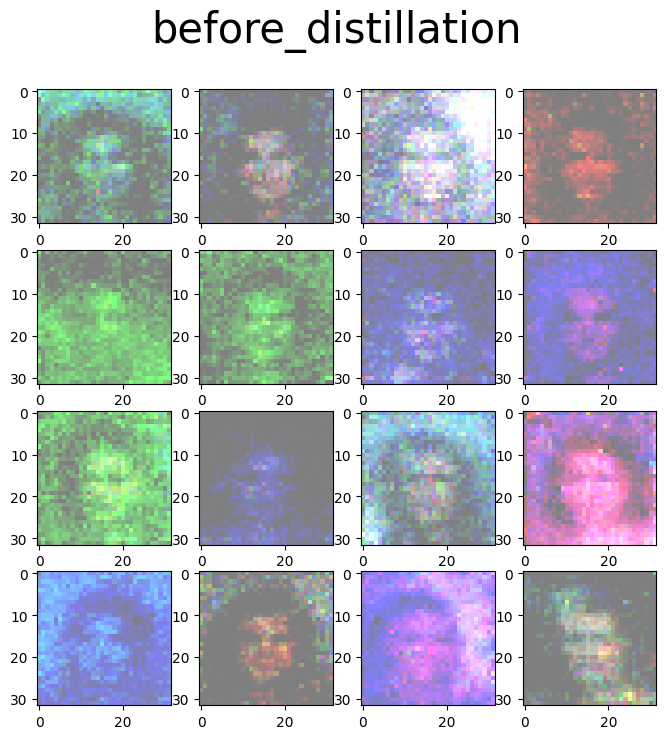

In [37]:
with torch.no_grad():
    noise = torch.randn((16, 3, 32, 32), device=device)
    generated = netG.compute_x0(noise, torch.full((16,), 1000 - 1, device=device))
    show_images(generated.clamp(0, 1), "before_distillation")

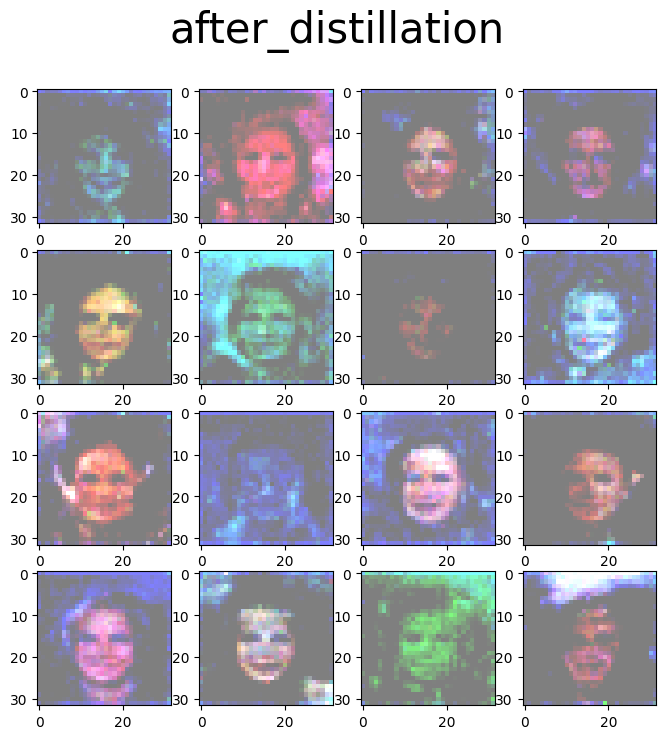

In [39]:
netG.load_state_dict(checkpoint['netG'])

with torch.no_grad():
    noise = torch.randn((16, 3, 32, 32), device=device)
    generated = netG.compute_x0(noise, torch.full((16,), 1000 - 1, device=device))
    show_images(generated.clamp(0, 1), "after_distillation")